# Source des donnees et bibliographie


https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/

https://raw.githubusercontent.com/maelfabien/

https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/

In [1]:
! pip install vega_datasets

     |████████████████████████████████| 210 kB 297 kB/s eta 0:00:01


# Importation des libraries

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from pandas import read_csv
from pandas.plotting import autocorrelation_plot

#from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
plt.style.use('seaborn')
%matplotlib inline 

# Preprocessing  data

## load data

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/maelfabien/COVID-19-Senegal/master/COVID_Dakar.csv",sep=";" )
df.tail()

,Date,Positif,Negatif,Age,Homme,Femme,Décédé,Guéri,Nationalité,Resident Senegal,Ville,Facteur,Source/Voyage,Hopital,Temps Hospitalisation (j)
723,27.03.20,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Importé,NaN,NaN,NaN
724,27.03.20,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Importé,NaN,NaN,NaN
725,27.03.20,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Contact,NaN,NaN,NaN
726,27.03.20,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Contact,NaN,NaN,NaN
727,27.03.20,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Communauté,NaN,NaN,NaN


## processing data

In [3]:
confirmed_df = df[df['Positif']==1]
confirmed = confirmed_df[['Date', 'Positif']]
confirmed_cases= confirmed[['Date', 'Positif']].groupby("Date").sum()

deaths_df = df[df['Décédé']==1]
deaths = deaths_df[['Date', 'Décédé']]
deaths_cases= deaths[['Date', 'Décédé']].groupby("Date").sum()

recoveries_df = df[df['Guéri']==1]
recoveries = recoveries_df[['Date', 'Guéri']]
recoveries_cases= recoveries[['Date', 'Guéri']].groupby("Date").sum()


negatif_df = df[df['Negatif']==1  ]
negatif = negatif_df[['Date', 'Negatif']]
negatif_cases=negatif[['Date', 'Negatif']].groupby("Date").sum()


## Descriptif Analysis

In [4]:
test1 = pd.DataFrame(confirmed_cases)
test2 = pd.DataFrame(negatif_cases)
total_cases = pd.concat([test1, test2], axis=1)
total_cases = total_cases.fillna(0)
total_cases['Negatif']
total = total_cases['Positif'] + total_cases['Negatif']
#prop = total_cases['Positif']/ total
#total_cases
total

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


02.03.20      1.0
03.03.20      2.0
04.03.20      2.0
06.03.20      2.0
07.03.20      2.0
08.03.20      2.0
09.03.20      6.0
10.03.20      1.0
11.03.20      8.0
12.03.20      6.0
13.03.20     11.0
14.03.20      3.0
15.03.20      2.0
16.03.20      9.0
17.03.20     44.0
18.03.20     27.0
19.03.20     22.0
20.03.20     56.0
21.03.20     31.0
22.03.20     85.0
23.03.20     61.0
24.03.20     59.0
25.03.20    142.0
26.03.20    130.0
27.03.20     14.0
dtype: float64

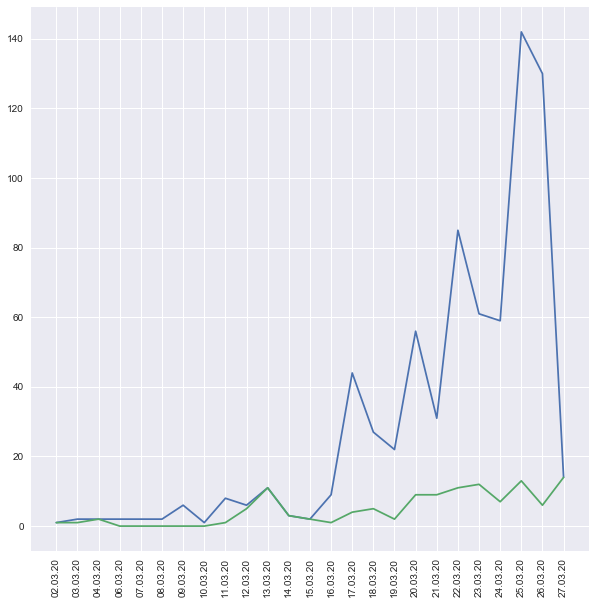

In [5]:
plt.figure(figsize=(10,10))
plt.plot(total)
plt.plot(total_cases['Positif'])
plt.xticks(rotation = 90)
plt.show()

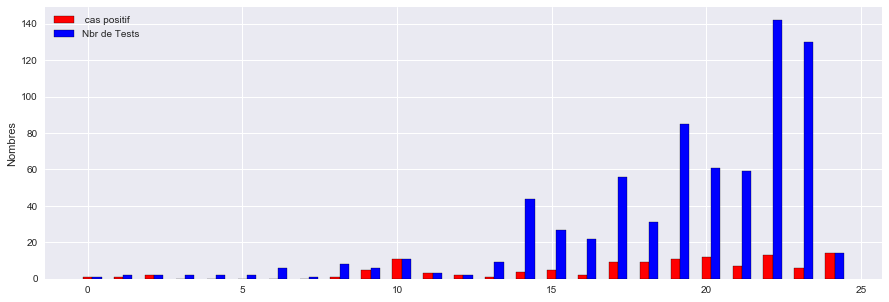

In [6]:
plt.figure(figsize=(15,5))
# width of the bars
barWidth = 0.3
# The x position of bars
r1 = np.arange(len(total_cases['Positif']))
r2 = [x + barWidth for x in r1]
 
# Create blue bars
plt.bar(r1,total_cases['Positif'], width = barWidth, color = 'red', edgecolor = 'black', capsize=7, label=' cas positif')
 
# Create cyan bars
plt.bar(r2, total, width = barWidth, color = 'blue', edgecolor = 'black', capsize=7, label='Nbr de Tests')
 
# general layout
#plt.xticks([r + barWidth for r in range(len(bars1))], ['cond_A', 'cond_B', 'cond_C'])
plt.ylabel('Nombres')
plt.legend()
 
# Show graphic
plt.show()

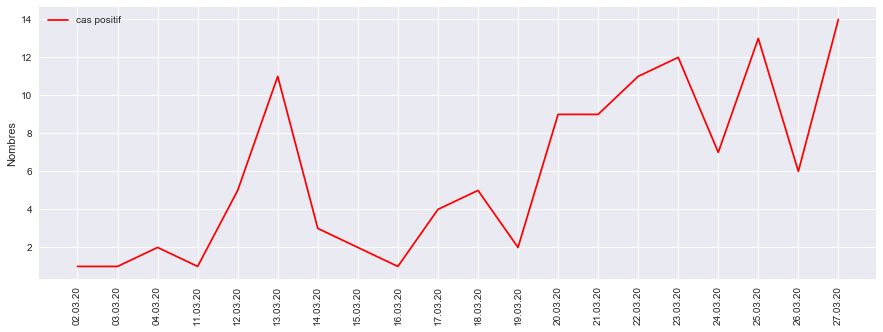

In [7]:
plt.figure(figsize= (15,5))
plt.plot(confirmed_cases, color = 'red', label = 'cas positif')
plt.xticks(rotation = 90)
plt.ylabel('Nombres')
plt.legend()
plt.show()

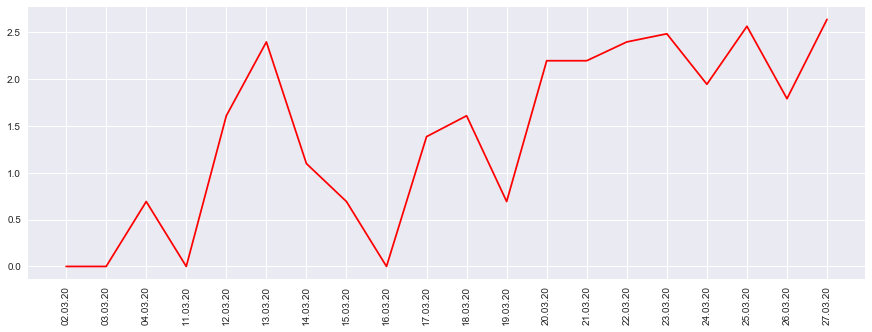

In [8]:
plt.figure(figsize= (15,5))
plt.plot(np.log(confirmed_cases), color = 'red')
plt.xticks(rotation = 90)
plt.show()

# Modelisation

## Preparation des donnees

In [9]:
days_since = np.array([i for i in range(len(confirmed_cases))]).reshape(-1, 1)
senegal_cases = np.array(confirmed_cases).reshape(-1, 1)


In [10]:
n = 10
days_in_future = n
future_forcast = np.array([i for i in range(len(confirmed_cases)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-n]


In [11]:
start = '03/03/2020'
start_date = datetime.datetime.strptime(start, '%d/%m/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%d/%m/%Y'))

In [12]:
## Split data train and test

In [13]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since, senegal_cases, test_size=0.25, shuffle=False) 

## SVM Model

In [14]:
# svm_confirmed = svm_search.best_estimator_
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=5, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred2 = svm_confirmed.predict(X_test_confirmed)
svm_pred2
svm_pred = svm_confirmed.predict(future_forcast)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


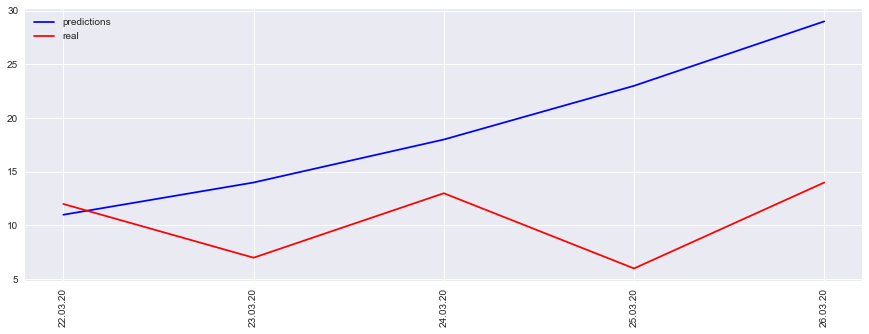

In [15]:
test = confirmed_cases.iloc[14:19]
test.reset_index(level=0, inplace=True)
test['Date']
plt.figure(figsize=(15,5))
plt.plot(test['Date'],np.round(svm_pred2), color = 'blue', label = 'predictions')
plt.plot(test['Date'] ,y_test_confirmed, color = 'red', label = 'real')
plt.xticks(rotation = 90)
plt.legend()
plt.show()

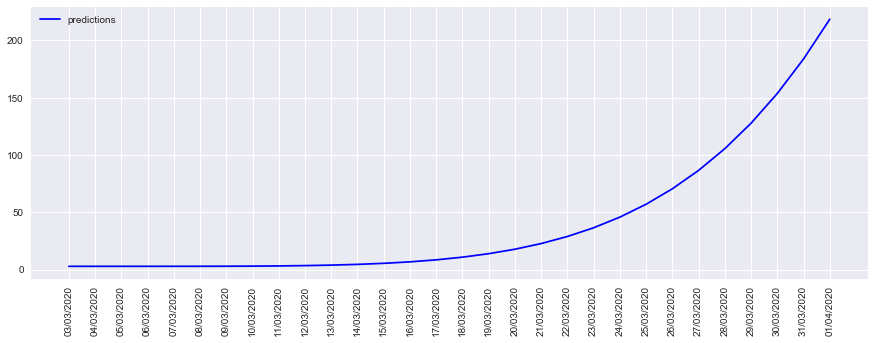

In [16]:
plt.figure(figsize=(15,5))
plt.plot(future_forcast_dates,svm_pred, color = 'blue', label = 'predictions')
#plt.plot(test['Date'] ,y_test_confirmed, color = 'red', label = 'real')
plt.xticks(rotation = 90)
plt.legend()
plt.show()


In [18]:
# Future predictions using Linear Regression 
print('Support Vectors Machines  future predictions:')
set(zip(future_forcast_dates[-11:], np.round(svm_pred[-11:])))

Support Vectors Machines  future predictions:


{('01/04/2020', 219.0),
 ('22/03/2020', 29.0),
 ('23/03/2020', 37.0),
 ('24/03/2020', 46.0),
 ('25/03/2020', 57.0),
 ('26/03/2020', 71.0),
 ('27/03/2020', 87.0),
 ('28/03/2020', 106.0),
 ('29/03/2020', 128.0),
 ('30/03/2020', 154.0),
 ('31/03/2020', 184.0)}

## Bayesian Ridge

In [19]:
# bayesian ridge 
tol = [1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2}

bayesian = BayesianRidge(fit_intercept=False, normalize=True)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.6s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           compute_score=False, copy_X=True,
                                           fit_intercept=False, lambda_1=1e-06,
                                           lambda_2=1e-06, n_iter=300,
                                           normalize=True, tol=0.001,
                                           verbose=False),
                   iid='warn', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                     0.0001],
                                        'lambda_2': [1e

In [21]:
bayesian_search.best_params_

{'tol': 0.01,
 'lambda_2': 0.0001,
 'lambda_1': 1e-06,
 'alpha_2': 1e-06,
 'alpha_1': 0.0001}

In [22]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

MAE: 3.2077217157341282
MSE: 10.815928534081923


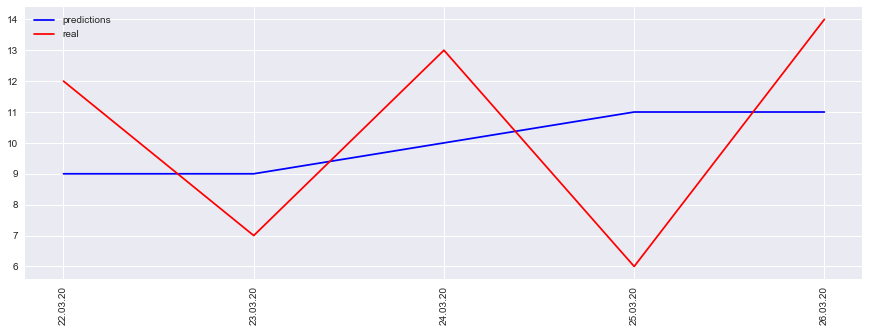

In [23]:

#test = confirmed_cases.iloc[14:19]
#test.reset_index(level=0, inplace=True)
test['Date']
plt.figure(figsize=(15,5))
plt.plot(test['Date'],np.round(test_bayesian_pred), color = 'blue', label = 'predictions')
plt.plot(test['Date'] ,y_test_confirmed, color = 'red', label = 'real')
plt.xticks(rotation = 90)
plt.legend()
plt.show()

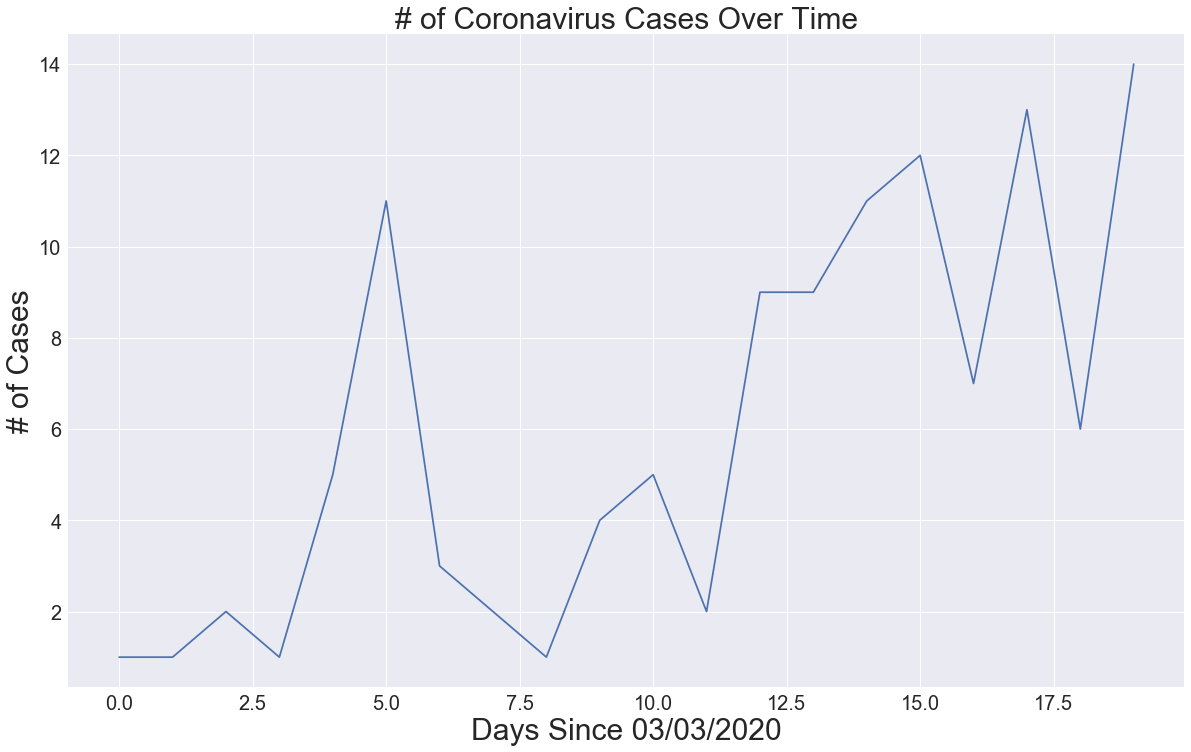

In [24]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, senegal_cases)
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 03/03/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

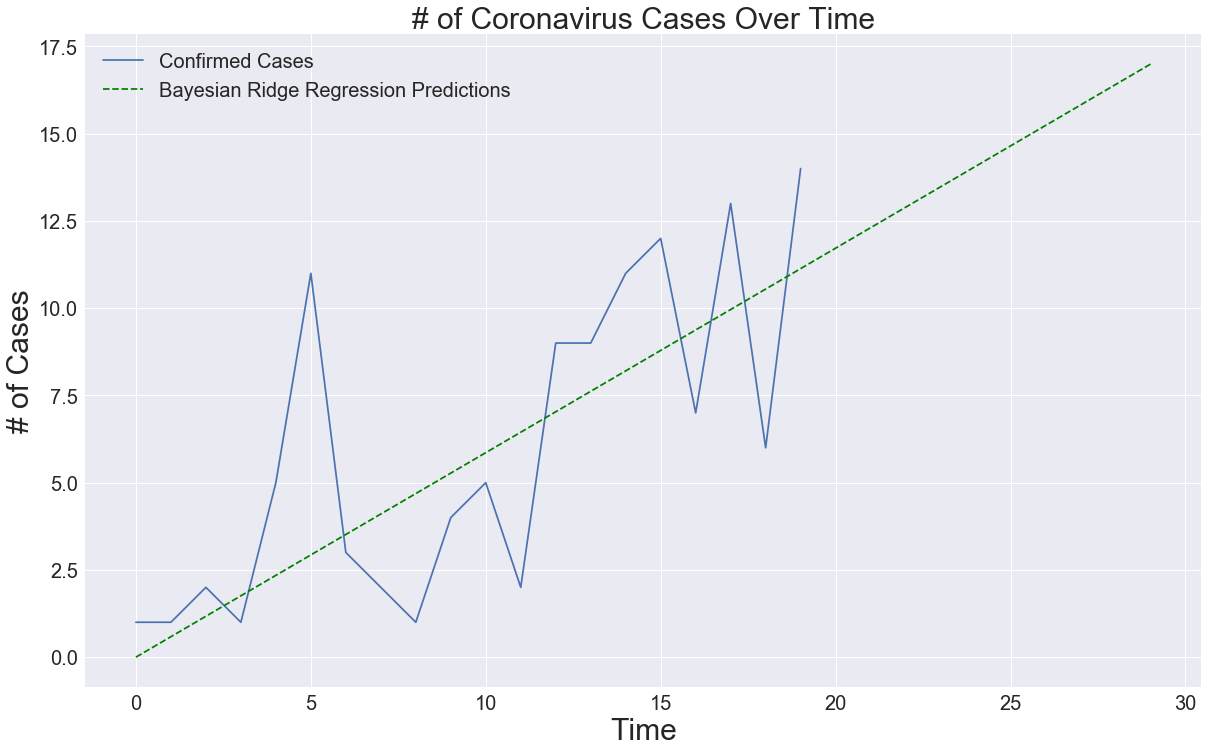

In [25]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, senegal_cases)
plt.plot(future_forcast, bayesian_pred, linestyle='dashed', color='green')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Time', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'Bayesian Ridge Regression Predictions'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [26]:
# Future predictions using Linear Regression 
print('Ridge regression future predictions:')
set(zip(future_forcast_dates[-10:], np.round(bayesian_pred[-10:]) ))

Ridge regression future predictions:


{('01/04/2020', 17.0),
 ('23/03/2020', 12.0),
 ('24/03/2020', 12.0),
 ('25/03/2020', 13.0),
 ('26/03/2020', 13.0),
 ('27/03/2020', 14.0),
 ('28/03/2020', 15.0),
 ('29/03/2020', 15.0),
 ('30/03/2020', 16.0),
 ('31/03/2020', 16.0)}

# Temporel Series Model

## Modele ARIMA

In [27]:
X = confirmed_cases
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]

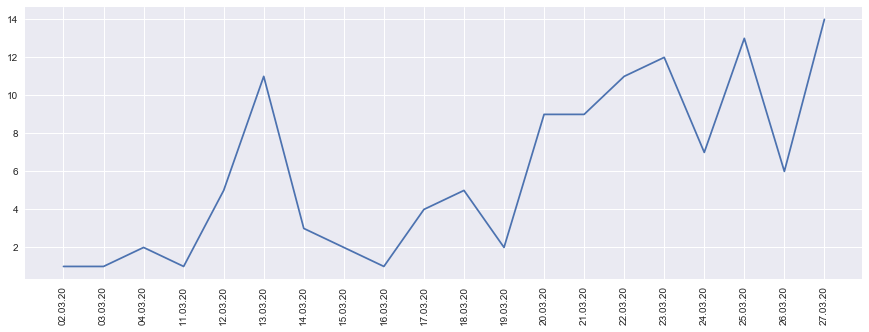

In [28]:
plt.figure(figsize=(15,5))
pyplot.plot(X)
pyplot.xticks(rotation = 90)
pyplot.show()

In [29]:
Y = confirmed_cases.values
#Y = confirmed_cases


train_size = int(len(Y) * 0.66)
train, test = Y[0:train_size], Y[train_size:len(Y)]
print('Observations: %d' % (len(Y)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))


Observations: 20
Training Observations: 13
Testing Observations: 7


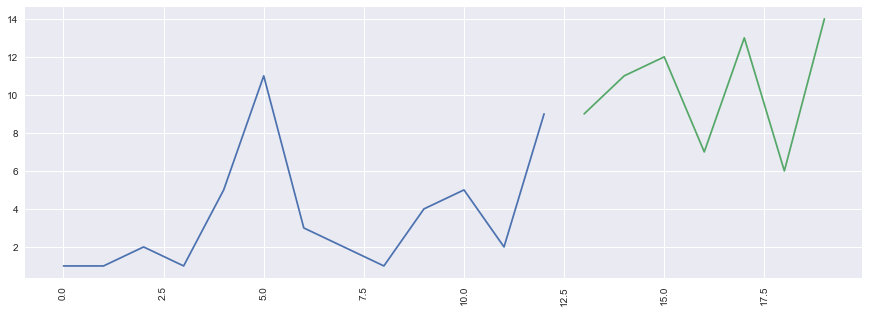

In [30]:
plt.figure(figsize=(15,5))
pyplot.plot(train)
pyplot.xticks(rotation = 90)
pyplot.plot([None for i in train] + [x for x in test])
pyplot.show()

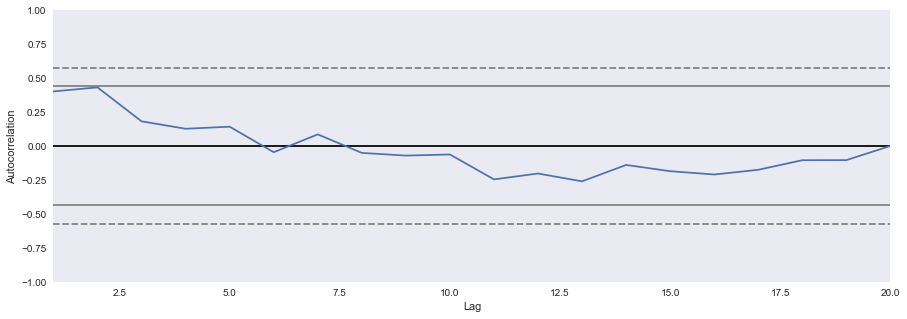

In [31]:

plt.figure(figsize=(15,5))
autocorrelation_plot(X)
pyplot.show()

In [32]:
# fit model
model = ARIMA(X, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:              D.Positif   No. Observations:                   19
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 -49.856
Method:                       css-mle   S.D. of innovations              3.229
Date:                Sat, 28 Mar 2020   AIC                            113.712
Time:                        01:31:00   BIC                            120.323
Sample:                             1   HQIC                           114.831
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.5923      0.370      1.602      0.133      -0.132       1.317
ar.L1.D.Positif    -0.6053      0.231     -2.625      0.021      -1.057      -0.153
ar.L2.D.Positif    -0.2439      

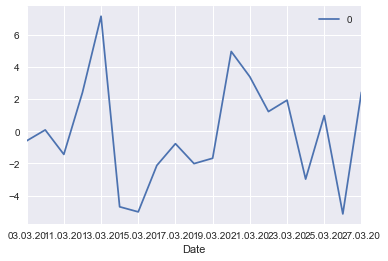

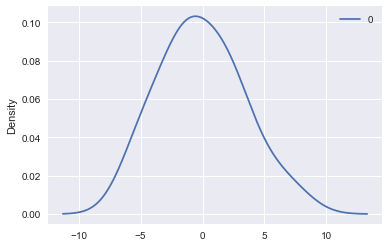

               0
count  19.000000
mean   -0.095942
std     3.348444
min    -5.136587
25%    -2.064845
50%    -0.592349
75%     2.173076
max     7.156164


In [33]:
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

In [34]:
Xvalues = confirmed_cases.values
size = int(len(Xvalues) * 0.66)
train, test = Xvalues[0:size], Xvalues[size:len(Xvalues)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(3,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))


predicted=7.877425, expected=9.000000
predicted=7.906081, expected=11.000000
predicted=10.021451, expected=12.000000
predicted=12.393545, expected=7.000000
predicted=9.256831, expected=13.000000
predicted=12.982886, expected=6.000000
predicted=10.094756, expected=14.000000


Test MSE: 17.409


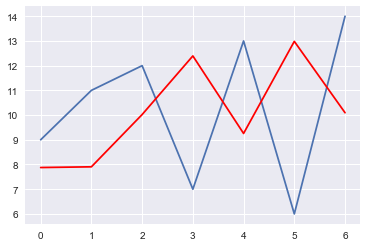

In [35]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

### Choose best parameters models ARIMA

In [36]:
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [37]:
import warnings
warnings.filterwarnings("ignore")
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(X.values, p_values, d_values, q_values)

Best ARIMANone MSE=inf


In [38]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error
 

In [39]:
# load dataset


# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 6)
q_values = range(0, 6)
warnings.filterwarnings("ignore")
evaluate_models(X.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=39.159
ARIMA(0, 0, 1) MSE=36.180
ARIMA(0, 0, 2) MSE=33.307
ARIMA(0, 0, 3) MSE=47.718
ARIMA(0, 1, 0) MSE=26.567
ARIMA(0, 1, 1) MSE=13.441
ARIMA(0, 1, 2) MSE=14.896
ARIMA(0, 2, 0) MSE=92.195
ARIMA(0, 2, 1) MSE=29.439
ARIMA(1, 0, 0) MSE=29.904
ARIMA(1, 1, 0) MSE=14.674
ARIMA(1, 2, 0) MSE=30.575
ARIMA(2, 0, 0) MSE=28.963
ARIMA(2, 1, 0) MSE=17.773
ARIMA(2, 2, 0) MSE=30.046
ARIMA(4, 0, 0) MSE=39.974
ARIMA(4, 1, 0) MSE=15.605
Best ARIMA(0, 1, 1) MSE=13.441


predicted=5.515568, expected=9.000000
predicted=6.850550, expected=11.000000
predicted=8.280357, expected=12.000000
predicted=9.694608, expected=7.000000
predicted=9.920343, expected=13.000000
predicted=10.868937, expected=6.000000
predicted=10.768421, expected=14.000000
Test MSE: 13.441


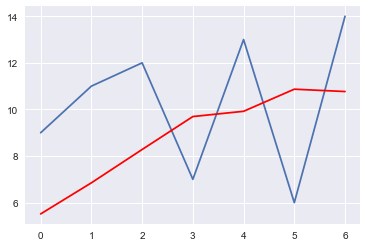

In [40]:
Xvalues = confirmed_cases.values
size = int(len(Xvalues) * 0.66)
train, test = Xvalues[0:size], Xvalues[size:len(Xvalues)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(0,1,1))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

Overview

This cheat sheet demonstrates 11 different classical time series forecasting methods; they are:

Autoregression (AR)
Moving Average (MA)
Autoregressive Moving Average (ARMA)
Autoregressive Integrated Moving Average (ARIMA)
Seasonal Autoregressive Integrated Moving-Average (SARIMA)
Seasonal Autoregressive Integrated Moving-Average with Exogenous Regressors (SARIMAX)
Vector Autoregression (VAR)
Vector Autoregression Moving-Average (VARMA)
Vector Autoregression Moving-Average with Exogenous Regressors (VARMAX)
Simple Exponential Smoothing (SES)
Holt Winter’s Exponential Smoothing (HWES)


# Autoregression (AR)

La méthode d'autorégression (AR) modélise la prochaine étape de la séquence en fonction linéaire des observations aux pas de temps précédents.
La notation du modèle implique de spécifier l'ordre du modèle p comme paramètre de la fonction AR, par ex. AR (p). 
Par exemple, AR (1) est un modèle d'autorégression de premier ordre.
La méthode convient aux séries chronologiques univariées sans tendance ni composantes saisonnières.


In [41]:
# AR example
from statsmodels.tsa.ar_model import AR
from random import random
# contrived dataset
data = confirmed_cases.values
size = int(len(data) * 0.66)
train, test = data[0:size], data[size:len(data)]
# fit model
model = AR(data)
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

#model_fit.predict(1,1)

[9.83899169]


In [42]:
# Future predictions using Linear Regression 
print('Model AR future predictions:')
set(zip(future_forcast_dates[23:23+7], np.round(model_fit.predict(len(data),len(data)+6)) ))

Model AR future predictions:


{('01/04/2020', 21.0),
 ('26/03/2020', 10.0),
 ('27/03/2020', 15.0),
 ('28/03/2020', 17.0),
 ('29/03/2020', 16.0),
 ('30/03/2020', 21.0),
 ('31/03/2020', 17.0)}

In [ ]:
plt.figure(figsize =(10,5))
plt.plot(future_forcast_dates[23:23+7], model_fit.predict(len(data),len(data)+6) )
plt.show()

# Moving Average (MA)


The moving average (MA) method models the next step in the sequence as a linear function of the residual errors from a mean process at prior time steps.
A moving average model is different from calculating the moving average of the time series.
The notation for the model involves specifying the order of the model q as a parameter to the MA function, e.g. MA(q). For example, MA(1) is a first-order moving average model.
The method is suitable for univariate time series without trend and seasonal components

La méthode de la moyenne mobile (MA) modélise la prochaine étape de la séquence en fonction linéaire des erreurs résiduelles d'un processus moyen à des pas de temps antérieurs.
Un modèle de moyenne mobile est différent du calcul de la moyenne mobile de la série chronologique.
La notation du modèle implique de spécifier l'ordre du modèle q en tant que paramètre de la fonction MA, par ex. MA (q). Par exemple, MA (1) est un modèle de moyenne mobile de premier ordre.
La méthode convient aux séries chronologiques univariées sans tendance ni composantes saisonnières

In [ ]:

# MA example
from statsmodels.tsa.arima_model import ARMA
from random import random
# contrived dataset
# fit model
model = ARMA(data, order=(0, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

In [ ]:
# Future predictions using Linear Regression 
print('Model MA future predictions:')
set(zip(future_forcast_dates[23:23+7], np.round(model_fit.predict(len(data),len(data)+6)) ))

# Autoregressive Moving Average (ARMA)

La méthode de la moyenne mobile autorégressive (ARMA) modélise la prochaine étape de la séquence en fonction linéaire des observations et des erreurs résiudales aux pas de temps précédents.

Il combine à la fois les modèles d'autorégression (AR) et de moyenne mobile (MA).

La notation du modèle implique de spécifier l'ordre des modèles AR (p) et MA (q) en tant que paramètres d'une fonction ARMA, par ex. ARMA (p, q). Un modèle ARIMA peut être utilisé pour développer des modèles AR ou MA.

La méthode convient aux séries chronologiques univariées sans tendance ni composantes saisonnières

In [ ]:
# ARMA example
from statsmodels.tsa.arima_model import ARMA
from random import random
# contrived dataset
# fit model
model = ARMA(data, order=(2, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)


In [ ]:
# Future predictions using Linear Regression 
print('Model ARMA future predictions:')
set(zip(future_forcast_dates[23:23+7], np.round(model_fit.predict(len(data),len(data)+6)) ))

# Seasonal Autoregressive Integrated Moving-Average (SARIMA)

La méthode SARIMA (Seasonal Autoregressive Integrated Moving Average) modélise la prochaine étape de la séquence en fonction linéaire des observations différenciées, des erreurs, des observations saisonnières différenciées et des erreurs saisonnières aux pas de temps précédents.

Il combine le modèle ARIMA avec la possibilité d'effectuer la même autorégression, différenciation et modélisation de la moyenne mobile au niveau saisonnier.

La notation du modèle implique de spécifier l'ordre des modèles AR (p), I (d) et MA (q) comme paramètres d'une fonction ARIMA et AR (P), I (D), MA (Q) et m paramètres au niveau saisonnier, par exemple SARIMA (p, d, q) (P, D, Q) m où «m» est le nombre de pas de temps dans chaque saison (la période saisonnière). Un modèle SARIMA peut être utilisé pour développer des modèles AR, MA, ARMA et ARIMA.

La méthode convient aux séries chronologiques univariées avec des composantes de tendance et / ou saisonnières.


In [ ]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random
# contrived dataset
#data = [x + random() for x in range(1, 100)]
# fit model
model = SARIMAX(data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

In [ ]:
# Future predictions using Linear Regression 
print('Model SARIMA future predictions:')
set(zip(future_forcast_dates[23:23+7], np.round(model_fit.predict(len(data),len(data)+6)) ))

# Multivariate time Series Model

## Vector Autoregression (VAR)

In [ ]:
# VAR example
from statsmodels.tsa.vector_ar.var_model import VAR
from random import random
# contrived dataset with dependency
data = pd.concat([confirmed_cases, total], axis=1)
# fit model
model = VAR(data)
model_fit = model.fit()
# make prediction
yhat = model_fit.forecast(model_fit.y, steps=1)
print(yhat)

In [ ]:
type(data)
type(confirmed_cases)
confirmed_cases
total
#type(total)
#total = pd.DataFrame(total)

In [ ]:
type(data)